# 任务介绍
任务描述

工地扬尘监管需求，除必要通道外，土堆需要盖防尘网，因此需要识别是否有土堆未盖防尘网。 需求：识别到指定ROI区域内出现裸露土堆，则产生告警。

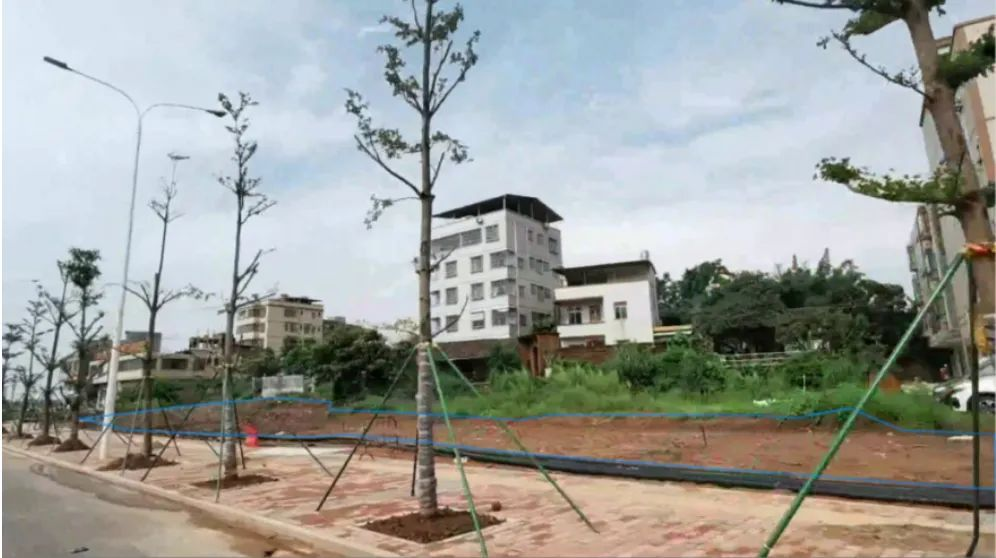
根据任务描述来看，拟采用语义分割来解决该任务。

评价指标

本榜最终得分采取准确率、算法性能绝对值综合得分的形式，具体如下：

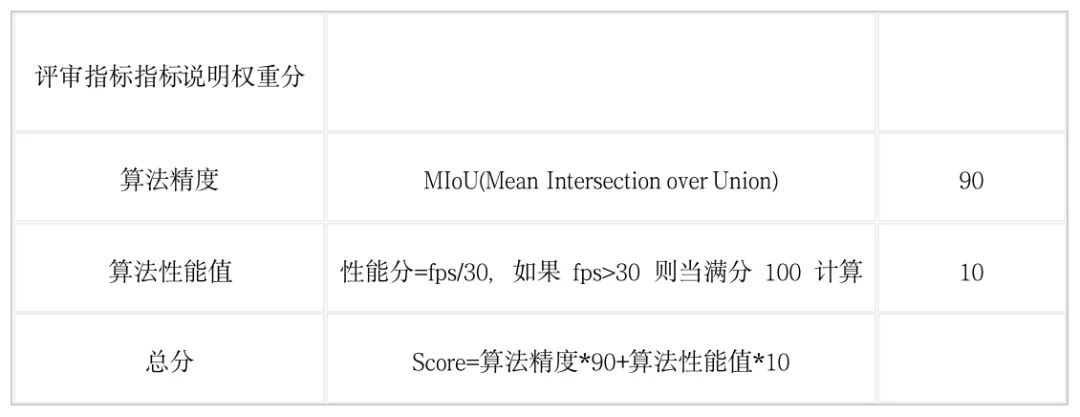

从算法评价指标来看，算法精度占很大一部分，因此首要考虑精度，然后再进一步提升模型的速度。值得注意的是由于极市采用的评测规则是将每张图片预测的结果保存为图片的形式，因此得到的结果fps相对比较低，大部分时间都耗在保存图片的io上。

数据集

从数据集来看，语义类别只有两个类别：裸土(值为1)，背景(值为0)，整个训练集一共有6665张图。

数据集示例如下图：
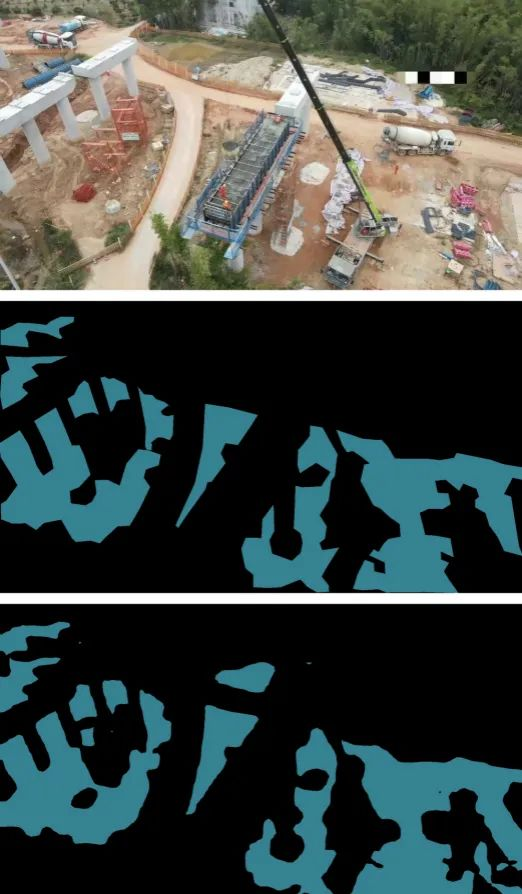

# 解决方案
模型选取

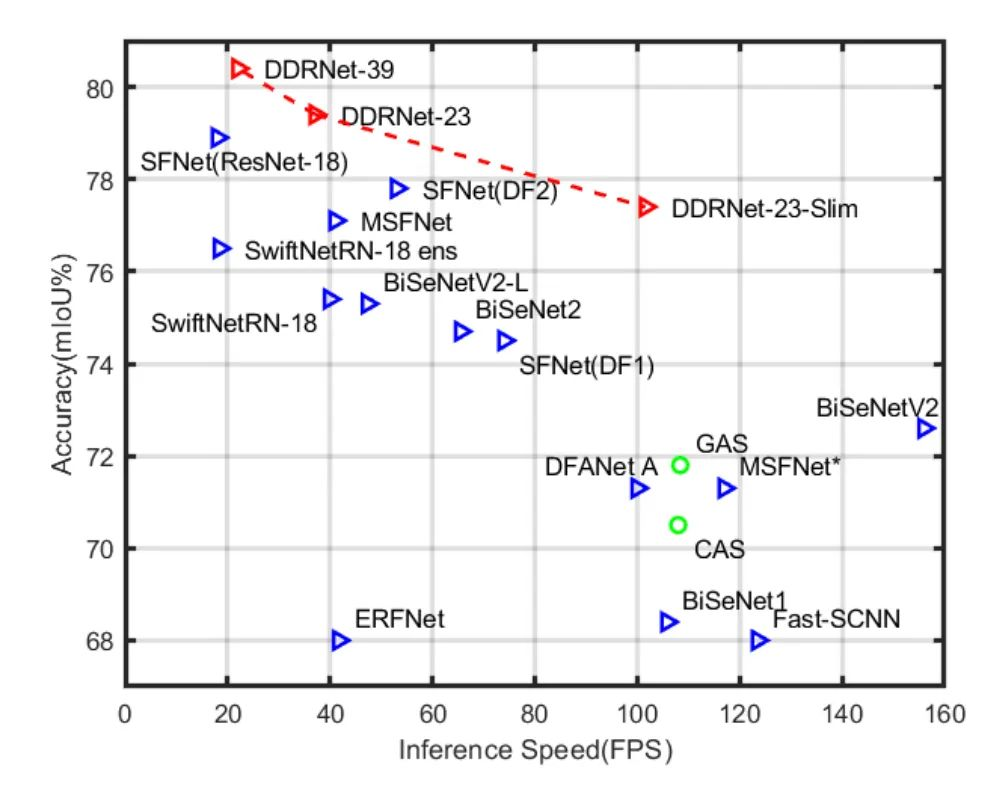
上图是来自Deep Dual-resolution Networks for Real-time and Accurate Semantic Segmentation of Road Scenes，该图描述了当前实时语义分割的一些优秀算法。从上图可以看出，DDRNet算法在速度和精度上都是较为优秀的算法。选择DDRNet-23-slim算法来作为Baseline。DDRNet的具体代码可以参考GitHub(本文采用该代码)。

编码训练
下面就Baseline的代码编码训练部分进行讲解。

环境

cuda 10.2
cudnn 7
python 3.8.8
pytorch 1.8.1
数据集划分

首先需要对数据集进行划分，这里采用trian:val=4:1的比例随机划分数据集。划分完数据集后要得到两个txt文档，分别是训练集和测试集对应的输入和标签映射关系。txt中每行是一组数据，格式如下：

/home/data/version/aa.jpg,/home/data/version/aa.png

原图的地址，标签掩码图的地址

数据集划分可参考如下代码：



In [ ]:
'''
Usage: python split_dataset.py /home/data
'''
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import os
import sys
import shutil
import pathlib
import random

import xml.etree.ElementTree as ET
import io

dataset_root = '/project/train/src_repo/dataset'
supported_fmt = ['.jpg', '.JPG']
       
if __name__ == '__main__':
    os.makedirs(dataset_root, exist_ok=True)
    if not os.path.exists(sys.argv[1]):
        print(f'{sys.argv[1]} 不存在!')
        exit(-1)

    # 遍历数据集目录下所有xml文件及其对应的图片
    dataset_path = pathlib.Path(sys.argv[1])
    found_data_list = []
    for mask_file in dataset_path.glob('**/*.png'):
        possible_images = [mask_file.with_suffix(suffix) for suffix in supported_fmt]
        supported_images = list(filter(lambda p: p.is_file(), possible_images))
        if len(supported_images) == 0:
            print(f'找不到对应的图片文件：`{mask_file.as_posix()}`')
            continue
        found_data_list.append({'image': supported_images[0], 'label': mask_file})

    # 随机化数据集，将数据集拆分成训练集和验证集，并将其拷贝到/project/train/src_repo/dataset下
    random.shuffle(found_data_list)
    train_data_count = len(found_data_list) * 4 / 5
    train_data_list = []
    valid_data_list = []
    for i, data in enumerate(found_data_list):
        if i < train_data_count:  # 训练集
            data_list = train_data_list
        else:  # 验证集
            data_list = valid_data_list
        data_list.append(data)

    with open(os.path.join(dataset_root, 'train.txt'), 'w') as f:
        for name in train_data_list:
            f.write(name['image'].as_posix() + ',' + name['label'].as_posix() + '\n')
    with open(os.path.join(dataset_root, 'val.txt'), 'w') as f:
        for name in valid_data_list:
            f.write(name['image'].as_posix() + ',' + name['label'].as_posix() + '\n')
    print('Done')

数据集和配置文件

由于Baseline代码的数据集加载代码都是针对通用数据集的，因此这里需要进行自定义数据集类。一共要修改的地方有两处。第一处增加自定义数据集类，这里可以参考给出的demo数据集类编码。主要更改的地方是数据集的语义类别和数据集的均值和方差, 加载数据集的方式。以下是自定义数据集类代码部分：

In [ ]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Ke Sun (sunk@mail.ustc.edu.cn)
# ------------------------------------------------------------------------------

import os

import cv2
import numpy as np
from PIL import Image

import torch
from torch.nn import functional as F

from pathlib import Path

from .base_dataset import BaseDataset

class Custom(BaseDataset):
    def __init__(self, 
                 root, 
                 list_path, 
                 num_samples=None, 
                 num_classes=2,
                 multi_scale=True, 
                 flip=True, 
                 ignore_label=-1, 
                 base_size=2048, 
                 crop_size=(512, 1024), 
                 downsample_rate=1,
                 scale_factor=16,
                 mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]):

        super(Custom, self).__init__(ignore_label, base_size,
                crop_size, downsample_rate, scale_factor, mean, std,)

        self.root = root
        self.list_path = list_path
        self.num_classes = num_classes

        self.multi_scale = multi_scale
        self.flip = flip
        
        self.img_list = [line.strip().split(',') for line in open(root+list_path)]

        self.files = self.read_files()
        if num_samples:
            self.files = self.files[:num_samples]
            
        self.imgs_npy = [(Path(Path(item['img']).parent.as_posix() + '_npy')/Path(item['img']).with_suffix('.npy').name, 
                          Path(Path(item['label']).parent.as_posix() + '_label_npy')/Path(item['label']).with_suffix('.npy').name if 'label' in item else None) for item in self.files]

        self.label_mapping = None
        self.class_weights = None
        
        self.cache = True
    
    def read_files(self):
        files = []
        if 'test' in self.list_path:
            for item in self.img_list:
                image_path = item
                name = os.path.splitext(os.path.basename(image_path[0]))[0]
                files.append({
                    "img": image_path[0],
                    "name": name,
                })
        else:
            for item in self.img_list:
                image_path, label_path = item
                name = os.path.splitext(os.path.basename(label_path))[0]
                files.append({
                    "img": image_path,
                    "label": label_path,
                    "name": name,
                    "weight": 1
                })
        return files
        
    def convert_label(self, label, inverse=False):
        if self.label_mapping is None:
            return label
        temp = label.copy()
        if inverse:
            for v, k in self.label_mapping.items():
                label[temp == k] = v
        else:
            for k, v in self.label_mapping.items():
                label[temp == k] = v
        return label
        
    def load_image(self, index):
        image, label = None, None
        if self.imgs_npy[index][0].exists():
            image = np.load(self.imgs_npy[index][0].as_posix())
        else:
            image = cv2.imread(self.files[index]['img'],
                               cv2.IMREAD_COLOR)
            if self.cache:
                self.imgs_npy[index][0].parent.mkdir(parents=True, exist_ok=True)
                np.save(self.imgs_npy[index][0].as_posix(), image)
        if "label" in self.files[index]:
            if self.imgs_npy[index][1].exists():
                label = np.load(self.imgs_npy[index][1].as_posix())
            else:
                label = cv2.imread(self.files[index]['label'],
                               cv2.IMREAD_GRAYSCALE)
                if self.cache:
                    self.imgs_npy[index][1].parent.mkdir(parents=True, exist_ok=True)
                    np.save(self.imgs_npy[index][1].as_posix(), label)
        
        return image, label
            

    def __getitem__(self, index):
        item = self.files[index]
        name = item["name"]
        
        image, label = self.load_image(index)
        
        size = image.shape

        if 'test' in self.list_path:
            image = self.input_transform(image)
            image = image.transpose((2, 0, 1))

            return image.copy(), np.array(size), name

        label = self.convert_label(label)

        image, label = self.gen_sample(image, label, 
                                self.multi_scale, self.flip)

        return image.copy(), label.copy(), np.array(size), name

    def multi_scale_inference(self, config, model, image, scales=[1], flip=False):
        batch, _, ori_height, ori_width = image.size()
        assert batch == 1, "only supporting batchsize 1."
        image = image.numpy()[0].transpose((1,2,0)).copy()
        stride_h = np.int(self.crop_size[0] * 1.0)
        stride_w = np.int(self.crop_size[1] * 1.0)
        final_pred = torch.zeros([1, self.num_classes,
                                    ori_height,ori_width]).cuda()
        for scale in scales:
            new_img = self.multi_scale_aug(image=image,
                                           rand_scale=scale,
                                           rand_crop=False)
            height, width = new_img.shape[:-1]
                
            if scale <= 1.0:
                new_img = new_img.transpose((2, 0, 1))
                new_img = np.expand_dims(new_img, axis=0)
                new_img = torch.from_numpy(new_img)
                preds = self.inference(config, model, new_img, flip)
                preds = preds[:, :, 0:height, 0:width]
            else:
                new_h, new_w = new_img.shape[:-1]
                rows = np.int(np.ceil(1.0 * (new_h - 
                                self.crop_size[0]) / stride_h)) + 1
                cols = np.int(np.ceil(1.0 * (new_w - 
                                self.crop_size[1]) / stride_w)) + 1
                preds = torch.zeros([1, self.num_classes,
                                           new_h,new_w]).cuda()
                count = torch.zeros([1,1, new_h, new_w]).cuda()

                for r in range(rows):
                    for c in range(cols):
                        h0 = r * stride_h
                        w0 = c * stride_w
                        h1 = min(h0 + self.crop_size[0], new_h)
                        w1 = min(w0 + self.crop_size[1], new_w)
                        h0 = max(int(h1 - self.crop_size[0]), 0)
                        w0 = max(int(w1 - self.crop_size[1]), 0)
                        crop_img = new_img[h0:h1, w0:w1, :]
                        crop_img = crop_img.transpose((2, 0, 1))
                        crop_img = np.expand_dims(crop_img, axis=0)
                        crop_img = torch.from_numpy(crop_img)
                        pred = self.inference(config, model, crop_img, flip)
                        preds[:,:,h0:h1,w0:w1] += pred[:,:, 0:h1-h0, 0:w1-w0]
                        count[:,:,h0:h1,w0:w1] += 1
                preds = preds / count
                preds = preds[:,:,:height,:width]

            preds = F.interpolate(
                preds, (ori_height, ori_width), 
                mode='bilinear', align_corners=config.MODEL.ALIGN_CORNERS
            )            
            final_pred += preds
        return final_pred

    def get_palette(self, n):
        palette = [0] * (n * 3)
        for j in range(0, n):
            lab = j
            palette[j * 3 + 0] = 0
            palette[j * 3 + 1] = 0
            palette[j * 3 + 2] = 0
            i = 0
            while lab:
                palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
                palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
                palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
                i += 1
                lab >>= 3
        return palette

    def save_pred(self, preds, sv_path, name):
        palette = self.get_palette(256)
        preds = np.asarray(np.argmax(preds.cpu(), axis=1), dtype=np.uint8)
        for i in range(preds.shape[0]):
            pred = self.convert_label(preds[i], inverse=True)
            save_img = Image.fromarray(pred)
            save_img.putpalette(palette)
            save_img.save(os.path.join(sv_path, name[i]+'.png'))

在进行训练之前，需要对训练的参数进行配置。网络输出维度为2。数据集的输入采用上面划分数据集得到的两个txt文档的地址。整个训练一共150 epochs，BATCH_SIZE_PER_GPU为32。最后一定要注意模型保存路径，这里可以设置为/project/train/models，这是平台保存模型的路径。

In [ ]:
CUDNN:
  BENCHMARK: true
  DETERMINISTIC: false
  ENABLED: true
GPUS: (0,)
OUTPUT_DIR: '/project/train/models'
LOG_DIR: '/project/train/models/log'
WORKERS: 4
PRINT_FREQ: 10

DATASET:
  DATASET: Custom
  ROOT: ''
  TEST_SET: '/project/train/src_repo/dataset/val.txt'
  TRAIN_SET: '/project/train/src_repo/dataset/train.txt'
  NUM_CLASSES: 2
MODEL:
  NAME: ddrnet_23_slim
  NUM_OUTPUTS: 2
  PRETRAINED: "pretrained_models/DDRNet23s_imagenet.pth"
  ALIGN_CORNERS: false
LOSS:
  USE_OHEM: true
  OHEMTHRES: 0.9
  OHEMKEEP: 131072
  BALANCE_WEIGHTS: [1, 0.4]
TRAIN:
  IMAGE_SIZE:
  - 1024
  - 576
  BASE_SIZE: 1024
  BATCH_SIZE_PER_GPU: 16
  SHUFFLE: true
  BEGIN_EPOCH: 0
  END_EPOCH: 150
  RESUME: false
  OPTIMIZER: sgd
  LR: 0.01
  WD: 0.0005
  MOMENTUM: 0.9
  NESTEROV: false
  FLIP: true
  MULTI_SCALE: true
  DOWNSAMPLERATE: 1
  IGNORE_LABEL: 255
  SCALE_FACTOR: 16
TEST:
  IMAGE_SIZE:
  - 1024
  - 576
  BASE_SIZE: 1024
  BATCH_SIZE_PER_GPU: 16
  FLIP_TEST: false
  MULTI_SCALE: true
  SCALE_LIST: [1]
  OUTPUT_INDEX: 1
  #CLASS_INDEX: [1,2,3]

训练

搞定了数据集的加载和代码的训练配置，那么接下来训练就是相当简单了。这里将之前的数据集划分还有启动训练的脚本命令合在一起得到了如下代码：

In [ ]:
project_root_dir=/project/train/src_repo
dataset_dir=/home/data
log_file=/project/train/log/log.txt

echo "Prepare environment..."
pip install -i https://mirrors.cloud.tencent.com/pypi/simple -r ${project_root_dir}/DDRNet/requirements.txt
echo "Prepare dataset..."
cd ${project_root_dir} && python split_dataset.py ${dataset_dir} | tee -a ${log_file}

echo "Start training..."
cd ${project_root_dir}/DDRNet
# export CUDA_VISIBLE_DEVICES=0
cfg_file=experiments/expressage/ddrnet23_slim.yaml
NGPUS=1
python -m torch.distributed.launch --nproc_per_node=$NGPUS tools/train.py --cfg $cfg_file | tee -a ${log_file}

echo "Convert model to onnx..."
python tools/export_onnx.py --cfg $cfg_file
python -m onnxsim /project/train/models/model.onnx /project/train/models/model_sim.onnx

训练脚本中最后有一部分是关于导出onnx模型的代码，这里加入这部分代码是为了后续采用TensorRT进行推理做准备。

# 推理测试

推理环境和模型转换
这里采用TensorRT进行模型推理加速(c++)

模型转换可参考BiSeNet代码给出的转换方法，具体如下：

In [ ]:
# 编译代码
mkdir -p tensorrt/build
cd tensorrt/build
cmake ..
make
# 最后会产生 ./segment 的二进制执行文件在build目录中
# 转换TensorRT模型
$ ./segment compile /path/to/onnx.model /path/to/saved_model.trt
# 添加 --fp16 采用fp16进行推理：
$ ./segment compile /path/to/onnx.model /path/to/saved_model.trt --fp16

如果不想通过上述方式转换TensorRT模型，可以采用转换工具 onnx2trt、trtexc等或者直接python转换

推理代码

整个推理部分包括：模型加载、图像预处理、推理预测、后处理，代码如下所示：

In [ ]:
"""
An example that uses TensorRT's Python api to make inferences for BiSeNet.
"""
import os
import shutil
import random
import sys
import threading
import time
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt

def get_img_path_batches(batch_size, img_dir):
    ret = []
    batch = []
    for root, dirs, files in os.walk(img_dir):
        for name in files:
            if len(batch) == batch_size:
                ret.append(batch)
                batch = []
            batch.append(os.path.join(root, name))
    if len(batch) > 0:
        ret.append(batch)
    return ret

class Seg_TRT(object):
    """
    description: A BiSeNet class that warps TensorRT ops, preprocess and postprocess ops.
    """

    def __init__(self, engine_file_path):
        # Create a Context on this device,
        self.cfx = cuda.Device(0).make_context()
        stream = cuda.Stream()
        runtime = trt.Runtime(trt.Logger(trt.Logger.ERROR))
        assert runtime
        
        # Deserialize the engine from file
        with open(engine_file_path, "rb") as f:
            engine = runtime.deserialize_cuda_engine(f.read())
        context = engine.create_execution_context()

        host_inputs = []
        cuda_inputs = []
        host_outputs = []
        cuda_outputs = []
        bindings = []

        for binding in engine:
            size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            cuda_mem = cuda.mem_alloc(host_mem.nbytes)
            # Append the device buffer to device bindings.
            bindings.append(int(cuda_mem))
            # Append to the appropriate list.
            if engine.binding_is_input(binding):
                self.input_w = engine.get_binding_shape(binding)[-1]
                self.input_h = engine.get_binding_shape(binding)[-2]
                host_inputs.append(host_mem)
                cuda_inputs.append(cuda_mem)
            else:
                self.output_w = engine.get_binding_shape(binding)[-1]
                self.output_h = engine.get_binding_shape(binding)[-2]
                host_outputs.append(host_mem)
                cuda_outputs.append(cuda_mem)

        # Store
        self.stream = stream
        self.context = context
        self.engine = engine
        self.host_inputs = host_inputs
        self.cuda_inputs = cuda_inputs
        self.host_outputs = host_outputs
        self.cuda_outputs = cuda_outputs
        self.bindings = bindings
        self.batch_size = engine.max_batch_size
        
        # self.img_mean = (0.46962251, 0.4464104,  0.40718787)
        # self.img_std = (0.27469736, 0.27012361, 0.28515933)
        self.img_mean = (0.485, 0.456, 0.406)
        self.img_std = (0.229, 0.224, 0.225)

    def infer(self, image_raw):
        threading.Thread.__init__(self)
        # Make self the active context, pushing it on top of the context stack.
        self.cfx.push()
        # Restore
        stream = self.stream
        context = self.context
        engine = self.engine
        host_inputs = self.host_inputs
        cuda_inputs = self.cuda_inputs
        host_outputs = self.host_outputs
        cuda_outputs = self.cuda_outputs
        bindings = self.bindings
        # if image_raw is constant, image_raw.shape[1] != self.input_w
        w_ori, h_ori = image_raw.shape[1], image_raw.shape[0]
        # print("image size: ", w_ori, " x ", h_ori)
        # Do image preprocess
        input_image = self.preprocess_image(image_raw)
        # Copy input image to host buffer
        np.copyto(host_inputs[0], input_image.ravel())
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(cuda_inputs[0], host_inputs[0], stream)
        # Run inference.
        context.execute_async(bindings=bindings, stream_handle=stream.handle)
        # Transfer predictions back from the GPU.
        cuda.memcpy_dtoh_async(host_outputs[0], cuda_outputs[0], stream)
        # Synchronize the stream
        stream.synchronize()
        # Remove any context from the top of the context stack, deactivating it.
        self.cfx.pop()
        # Here we use the first row of output in that batch_size = 1
        output = host_outputs[0]
        
        # Do postprocess
        output = output.reshape(self.output_h, self.output_w).astype('uint8')
        if self.output_w != w_ori or h_ori != self.output_h:
            output = cv2.resize(output, (w_ori, h_ori), interpolation=cv2.INTER_NEAREST)
        
        # palette = np.random.randint(0, 256, (256, 3), dtype=np.uint8)
        # output = palette[output]
        return output

    def destroy(self):
        # Remove any context from the top of the context stack, deactivating it.
        self.cfx.pop()

    def preprocess_image(self, image_raw):
        """
        description: Read an image from image path
        param:
            image_raw: numpy, raw image
        return:
            img_input:  the processed image
        """
        if self.input_w != image_raw.shape[1] or self.input_h != image_raw.shape[0]:
            img_resize = cv2.resize(image_raw, (self.input_w, self.input_h), cv2.INTER_LINEAR)[:, :, ::-1] #bgr2rgb
        else:
            img_resize = image_raw[:, :, ::-1] #bgr2rgb
        img_input = np.transpose(img_resize, [2, 0, 1]) # hwc2chw
        
        img_input = img_input.astype(np.float32) / 255.0
        img_mean = np.array(self.img_mean, dtype=np.float32).reshape(3, 1, 1)
        img_std = np.array(self.img_std, dtype=np.float32).reshape(3, 1, 1)
        img_input = (img_input - img_mean) / img_std
        
        # expand dims
        img_input = np.expand_dims(img_input, axis=0)
        
        return img_input

    def get_raw_image(self, image_path_batch):
        """
        description: Read an image from image path
        """
        for img_path in image_path_batch:
            return cv2.imread(img_path)
    
    def get_raw_image_zeros(self, image_path_batch=None):
        """
        description: Ready data for warmup
        """
        for _ in range(self.batch_size):
            return np.zeros([self.input_h, self.input_w, 3], dtype=np.uint8)


class inferThread(threading.Thread):
    def __init__(self, bisenet, image_path_batch):
        threading.Thread.__init__(self)
        self.bisenet = bisenet
        self.image_path_batch = image_path_batch

    def run(self):
        batch_image_raw = self.bisenet.infer(self.bisenet.get_raw_image(self.image_path_batch))

class warmUpThread(threading.Thread):
    def __init__(self, bisenet):
        threading.Thread.__init__(self)
        self.bisenet = bisenet

    def run(self):
        batch_image_raw = self.bisenet.infer(self.bisenet.get_raw_image_zeros())



if __name__ == "__main__":
    # load custom engine
    engine_file_path = "build/model.trt"  # the generated engine file
    
    if len(sys.argv) > 1:
        engine_file_path = sys.argv[1]

    if os.path.exists('output/'):
        shutil.rmtree('output/')
    os.makedirs('output/')
    # a hrnet instance
    bisenet = Seg_TRT(engine_file_path)
    try:
        print('batch size is', bisenet.batch_size)  # batch size is set to 1!
        
        image_dir = "samples/"
        image_path_batches = get_img_path_batches(bisenet.batch_size, image_dir)

        for i in range(10):
            # create a new thread to do warm_up
            thread1 = warmUpThread(bisenet)
            thread1.start()
            thread1.join()
        for batch in image_path_batches:
            # create a new thread to do inference
            thread1 = inferThread(bisenet, batch)
            thread1.start()
            thread1.join()
    finally:
        # destroy the instance
        bisenet.destroy()

from trt import *
import json
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import logging as log
import shutil


def inferThread(image_path):
    input_image = cv2.imread(image_path)
    return (input_image, image_path)

def writeThread(output_path, output):
    cv2.imwrite(output_path, output)
    return output_path

pool = ThreadPoolExecutor(max_workers=16)

infer_task = []

write_task = []
      
def init():

    """Initialize model
    Returns: model
    """
    onnx_file_path = "/project/train/models/model_sim.onnx"
    engine_file_path = "/usr/local/ev_sdk/model/model.trt"
    if not os.path.exists(engine_file_path):
        os.system("/usr/local/ev_sdk/3rd/BiSeNet/bin/segment compile " + onnx_file_path + " " + engine_file_path + " --fp16")
    net = Seg_TRT(engine_file_path)
    for i in range(10):
        # create a new thread to do warm_up
        thread1 = warmUpThread(bisenet)
        thread1.start()
        thread1.join()
    return net

def process_image(handle=None,input_image=None,args=None, **kwargs):

    """Do inference to analysis input_image and get output
    Attributes:
        handle: algorithm handle returned by init()
        input_image (numpy.ndarray): image to be process, format: (h, w, c), BGR
        args: string in JSON format, format: {
            "mask_output_path": "/path/to/output/mask.png"
        }
    Returns: process result
    """
    args_dict =json.loads(args)
    mask_output_path = args_dict['mask_output_path']
    output = handle.infer(input_image)
    cv2.imwrite(mask_output_path, output)
    return json.dumps({'model_data': {'mask': mask_output_path}, 'mask': mask_output_path},indent=4)

if __name__ == '__main__':
    # Test API
    import time
    img = cv2.imread('../data/test.jpg')
    predictor = init()
    s = time.time()
    for i in range(10):
        res = process_image(predictor, img, "{\"mask_output_path\":\"./out.png\"}")
    print((time.time() - s) /10 )
    print(res)
    predictor.destroy()

推理加速

以上代码只是简单的进行推理，速度并不会很快，可以从以下几个方面考虑进行速度优化：

图片前处理包括Resize和均值方差处理，这些处理可以在GPU中进行
后处理中还有一个图片Resize操作，也可以将这个操作放到GPU上进行。
对于以上两个方面有两种处理思路：

第一个可以通过CUDA编程实现，第二个Resize可以嵌入到模型处理
将以上两个处理都嵌入到模型里

结果展示

采用推理加速中第一种思路得到如下推理结果：
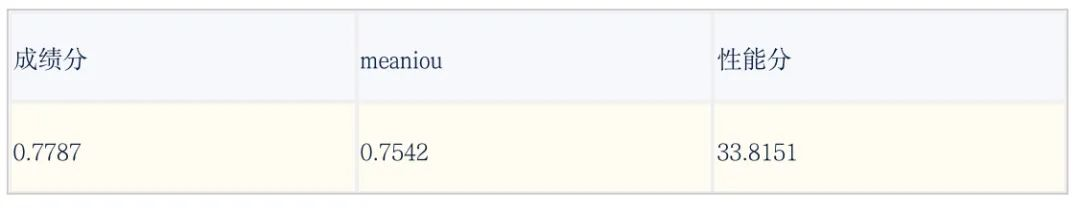
可视化结果
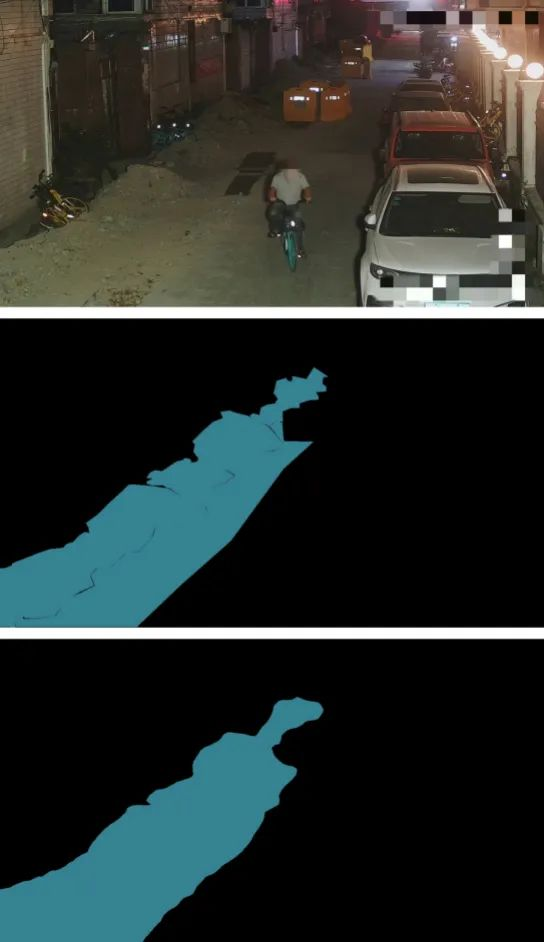
第一张图是原图，第二张是GT，第三张图是预测分割图。

讨论与总结

1.在保证精度的前提下，尽可能地想办法提升模型的速度，可以通过CUDA编程等方法实现。

2.寻找一个好用的模型也是很关键的。

Reference

[1] https://github.com/CoinCheung/BiSeNet

[2] https://github.com/chenjun2hao/DDRNet.pytorch

[3] https://github.com/ydhongHIT/DDRNet

[4] https://github.com/wang-xinyu/tensorrtx

[5] https://zhuanlan.zhihu.com/p/479290520